In [1]:
import numpy as np
import librosa

import os
import time
import cmath

# This is to force CPU evaluation since we probably train on a bigger GPU than I have
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
import keras.layers as layers
from keras import backend as K
from keras.utils import plot_model
from keras import regularizers
from keras import layers

#import matplotlib.pyplot as plt
#%matplotlib inline

Using TensorFlow backend.


In [2]:
# Check if we have a GPU
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1



In [0]:
# %load "NN Audio Core.py"

import librosa
import numpy as np
import cmath
import math
import os

# Constants and settings
DTYPE = 'float32'

WINDOW_SIZE = 55  # Has to be odd
TARGET_COL = WINDOW_SIZE//2

# stft values
N_FFT = 1024 # 512 recommended for speech, music typically 2048
FFT_BINS = 513

HOP_LENGTH = 128 # Required for good round trip quality

# Shared functions

def get_ft(wav):
    c = librosa.stft(wav, hop_length=HOP_LENGTH, n_fft=N_FFT)
    return c

def get_ft_from_file(file):
    filename = os.fsdecode(file)
    wav, rate = librosa.core.load(filename)
    return get_ft(wav)

def inv_ft(ft):
    return librosa.istft(ft, hop_length=HOP_LENGTH)

# This is an approximation - much better ways to compare voice quality exist, but this works fine
def diff_ft(ft1, ft2):
    per_sample = np.sum(abs(ft1-ft2), axis=0)
    return np.average(per_sample)


################################################################################
# Pitch & sample encoding functions

# Low cut off at bin 3 ~65hz (C2) - seems like 125hz should be safe but keeping the low end
# High cut off bin 300 ~6500hz - 5000hz sounded OK, but keeping some just in case
# These are based on N_FFT 1024
LOW_BIN = 3 
HIGH_BIN = 340
SAMPLE_BINS = HIGH_BIN-LOW_BIN

freq = librosa.fft_frequencies(sr=22050, n_fft=N_FFT)
LOW_FREQ = freq[LOW_BIN]
HIGH_FREQ = freq[HIGH_BIN]
SAMPLE_OCTAVES = math.log(HIGH_FREQ/LOW_FREQ,2)
BINS_PER_OCTAVE = 20  # Tested empirically this sounds fine (15 was also OK so this should be safe)


# Number of bins in rescaled pitch representation of the ft
PITCH_BINS = math.floor(SAMPLE_OCTAVES * BINS_PER_OCTAVE)

# S = sample space, which is frequency  P = pitch space, which is rescaled so pitches are constant space appart
def S_ix(p_ix):
    return SAMPLE_OCTAVES * ((SAMPLE_BINS/SAMPLE_OCTAVES + 1)**(p_ix/PITCH_BINS) -1 )

def P_ix(s_ix):
    return PITCH_BINS * math.log((1+s_ix/SAMPLE_OCTAVES),2)/math.log((1 + SAMPLE_BINS/SAMPLE_OCTAVES),2)

# Project X onto returned array Y using a list of ascending ys of len(X) with maximum value of leng(Y), so that
# where multiple ys's map to a single index i in X, assign X[i] to Y[those ys's]
# where a single yx maps to multiple indices in X, assign X[these i's] of X[ys]
def squash_stretch(ys, X, Ylen):
    Y = np.zeros((Ylen))
    i = 0
    while i < (len(ys)-1):
        xh = i
        if (math.floor(ys[i+1]) > math.floor(ys[i]+1)):
            #print("Batch assigning X[i] to Y[ys[i]:ys[i+1]] ",i, ys[i], ys[i+1])
            Y[ys[i]:ys[i+1]] = X[i]
            i += 1
        else:
            while (math.floor(ys[i]) == math.floor(ys[xh])) and (xh < len(ys)-1):
                xh += 1
            if (xh > i+1):
                Y[ys[i]] = 0
                #print("Averaging X[i,xh] into Y[ys[i]] ", i, xh, ys[i])
                Y[ys[i]] = np.average(X[i:xh])
                i = xh
            else:
                #print("Straight map X[i] to Y[ys[i]] ", i, ys[i])
                Y[ys[i]] = X[i]
                i += 1
        #print (i, ys[i], ys[xh])
    return Y

# Takes samples and rescales to pitch (log of frequencies so space between same pitch is constant)
# Output is samples, then rescaled magnitudes in shape (sample_count, PITCH_BINS)
def pitch_scale(st):
    si = list(range(SAMPLE_BINS))
    pi = [math.floor(P_ix(x)) for x in si]
    pt = np.empty((st.shape[0], PITCH_BINS))
    for i in range(st.shape[0]):
        pt[i,:] = squash_stretch(pi, st[i,:], PITCH_BINS)
    return pt

def sample_scale(pt):
    pi = list(range(PITCH_BINS))
    si = [math.floor(S_ix(x)) for x in pi]
    st = np.empty((pt.shape[0],SAMPLE_BINS))
    for i in range(pt.shape[0]):
        st[i,:] = squash_stretch(si, pt[i,:], SAMPLE_BINS)
    return st

# Sample output is ft converted to magnitude and .T to get samples then ft
# Only returns 'interesting' samples - between LOW_ and HIGH_ bins, so output shape is (sample_count, SAMPLE_BINS)
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples[:,LOW_BIN:HIGH_BIN]

def rebuild_fft(samples, original_fft):
    fft = np.zeros((samples.shape[0], FFT_BINS))
    fft[:,LOW_BIN:HIGH_BIN] = samples
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = fft.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)


In [4]:
# If on google colab, run this
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# For local data
samples=100000
frames_file = "fsamples-P" + str(PITCH_BINS) + "-" + str(samples)
targets_file = "ftargets-P"+ str(PITCH_BINS) + "-" +str(samples)
frames = np.memmap("f://audiodata//"+frames_file, mode='r', dtype=DTYPE, shape=(samples, PITCH_BINS, 1))
targets = np.memmap("f://audiodata//"+targets_file, mode='r', dtype=DTYPE, shape=(samples, PITCH_BINS))

In [0]:
# Data access for Colab
# Move data to VM local drive for reliable access
drive_data = '/content/drive/My Drive/Projects/Audio Separation/Data/'
os.chdir(drive_data)

import shutil
samples = 100000
frames_file = "fsamples-P" + str(PITCH_BINS) + "-" + str(samples)
targets_file = "ftargets-P"+ str(PITCH_BINS) + "-" +str(samples)
shutil.copy(frames_file, "/content/")
shutil.copy(targets_file, "/content/")

os.chdir("/content")

# for testing identity mapping : #frames = np.memmap("ftargets-"+str(samples), mode='r', dtype=DTYPE, shape=(samples, FFT_BINS, 1))

frames = np.memmap(frames_file, mode='r', dtype=DTYPE, shape=(samples, PITCH_BINS, 1))
targets = np.memmap(targets_file, mode='r', dtype=DTYPE, shape=(samples, PITCH_BINS))

In [0]:
# Code to generate input, target, and verification data
# From https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, input_array, target_array, batch_size=32, shuffle=True):
        'Initialization'
        self.input_array = input_array
        self.target_array = target_array
        self.dim = (WINDOW_SIZE,PITCH_BINS) # Input data shape
        self.batch_size = batch_size
        self.list_IDs = list_IDs  # the set of allowed IDs to use as addresses for frames and target samples
        self.n_channels = 1
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, PITCH_BINS), dtype=DTYPE)

        # Generate data
        half_win = WINDOW_SIZE // 2
        for i, ID in enumerate(list_IDs_temp):
            # Store sample & target
            X[i,] = self.input_array[ID-half_win:ID+half_win+1,:,:]
            y[i] = self.target_array[ID,:]

        return X, y

In [0]:
# Prepare the generator
validation_split = 0.05
batch_size = 256

# Available IDs
all_IDs = np.arange(WINDOW_SIZE//2, frames.shape[0]-WINDOW_SIZE//2)
np.random.shuffle(all_IDs)

validation_cut = int(np.floor(len(all_IDs) * (1-validation_split)))
validation_IDs = all_IDs[validation_cut:]
train_IDs = all_IDs[0:validation_cut-1]

training_generator = DataGenerator(train_IDs, frames, targets, batch_size=batch_size)
validation_generator = DataGenerator(validation_IDs, frames, targets, batch_size=batch_size)


In [0]:
# Network building functions
def conv_set(depth, kernel, strides, name, input, padding='valid'):
  conv = layers.Conv2D(depth, kernel_size=kernel, strides=strides, padding=padding, activity_regularizer=regularizers.l2(L2Reg), use_bias = False, name=name+"_conv")(input)
  norm = layers.BatchNormalization()(conv)
  return layers.LeakyReLU(alpha=ALPHA, name=name+"_LRelu")(norm)

def pool_set(size, strides, name, input):
  pool = layers.MaxPooling2D(pool_size=size, strides=strides, name=name+"_pool")(input)
  return layers.LeakyReLU(alpha=ALPHA)(pool)


# from https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

# TODO make this actually work!!!
def res_conv_block(f, filters, name, block, X):
  F1, F2, F3 = filters 
  X_shortcut = X
  ## Main path
  # First component
  X = conv_set(F1, (1,1), (1,1), name+"_res_conv_" + block + "_1", X)
  X = conv_set(F2, (f,f), (1,1), name+"_res_conv_" + block + "_2", X)
  X = conv_set(F3, (1,1), (1,1), name+"_res_conv_" + block + "_3", X)

  #X_shortcut = conv_set(F3, (1,1), (2,2), name+"_res_conv_shortcut_" + block, X)
  #X = layers.add([X, X_shortcut])
  return X

def Bus(bus, name, width, X):
  B = layers.Dense(width, activity_regularizer=regularizers.l2(L2Reg), name="bus_input_dense"+name)(layers.Flatten()(X))
  B = layers.concatenate([bus, B], name="bus_merge_"+name)
  B = layers.Dense(width, activity_regularizer=regularizers.l2(L2Reg), name="bus_dense_"+name)(B)
  return B

# X is batch, frames, bin, layers
def Harmonics_fn(X, bins_per_octave):
  Trimmed_X = K.slice(X, [0,0,0,0], [-1,-1,X.shape[2]-bins_per_octave,-1])
  Shift_X =  K.slice(X, [0,0,bins_per_octave,0], [-1,-1,-1,-1])
  return K.concatenate([Trimmed_X, Shift_X])

In [25]:
# Real model (eventually)
ALPHA = 0.05
L2Reg = 0.0000 # bumping this up to 0.000005 didn't seem very good

inputs = layers.Input(shape=(WINDOW_SIZE,PITCH_BINS,1)) # Full window

NARROW_VIEW = 15
BUS_WIDTH = 150

# WARNING - if I put a constant in the lambda function, it causes an error when loading the model
def sub_samples(samples, n, window_size):
    half_cut = (window_size - n) // 2
    return samples[:,half_cut:-half_cut,:,:]
    
# process inputs into subsets of interest
input_slice = layers.Lambda(sub_samples, arguments = {'n':1, 'window_size':WINDOW_SIZE}, name="targetslice")(inputs)
narrow_view = layers.Lambda(sub_samples, arguments = {'n':NARROW_VIEW, 'window_size':WINDOW_SIZE}, name="narrow_view")(inputs)

# zoomed out view
X = layers.AveragePooling2D(pool_size=(3,3), strides=(2,2), name="broad_pool1")(inputs)
X = conv_set(32,(3,6), (1,2), "bconv1", X)
X = conv_set(64, (3,6), (1,1), "bconv2", X)
#side = conv_set(16, (4,10), (1,3), "side_prep1", X)
#bus = layers.Dense(BUS_WIDTH, activity_regularizer=regularizers.l2(L2Reg), name="bus_initial_dense")(layers.Flatten()(side))  # Start of side path
X = conv_set(128, (3,3), (1,1), "bconv3", X)
X = conv_set(32, (3,3), (1,1), "bconv4", X)
#side = conv_set(16, (2,3), (1,1), "side_prep2", X)
#bus = Bus(bus, "b3", BUS_WIDTH, side)
X = pool_set((4,4), (2,2), "bpool2", X)
X = conv_set(16, (2,2), (1,1), "bconv5", X)
X = layers.BatchNormalization(name="b_norm")(X)
flat_b = layers.Flatten(name="flat_b")(X)

# narrow view
X = conv_set(32, (3,3), (1,1), "conv0", narrow_view)
X = conv_set(128, (3,3), (1,2), "conv1", X)
X = conv_set(128, (3,3), (1,1), "conv2", X)
#side = conv_set(16, (4,10), (1,5), "side_prep3", X)
#bus = Bus(bus, "n1", BUS_WIDTH, side)
X = pool_set((2,3), (1,2), "pool1", X)
#X = conv_set(128, (3,7), (1,2), "conv3", X)
#side = conv_set(16, (4,10), (1,3), "side_prep4", X)
#bus = Bus(bus, "n2", BUS_WIDTH, side)
X = conv_set(128, (3,3), (1,1), "conv4", X)
X = conv_set(32, (3,3), (1,1), "conv5", X)
X = pool_set((2,2), (1,1), "pool2", X)
X = layers.BatchNormalization(name="n_norm")(X)
flat_n = layers.Flatten(name="flat_n")(X)

# harmonics view
H = layers.Lambda(Harmonics_fn, arguments={'bins_per_octave':BINS_PER_OCTAVE}, name="harmonics1")(narrow_view)
H = layers.Lambda(Harmonics_fn, arguments={'bins_per_octave':BINS_PER_OCTAVE}, name="harmonics2")(H)
H = conv_set(128,(4,4), (1,2), "hconv0", H)
H = conv_set(256,(1,1), (1,1), "hconv1", H)
H = pool_set((2,3), (1,2), "hpool0", H)
H = conv_set(64,(5,5), (1,1), "hconv2", H)
#H = conv_set(32,(5,5), (1,2), "hconv4", H)
H = conv_set(32,(5,5), (1,1), "hconv5", H)
H = conv_set(32,(2,3), (1,1), "hconv6", H)
flat_h = layers.Flatten(name="flat_h")(H)


# Side bus completely removed for now as I simplify
flat = layers.concatenate([flat_b, flat_n, flat_h], name="merge_modes")

flat_in = layers.Flatten(name="flatten")(input_slice)

flat_drop = layers.Dropout(rate=0.2)(flat)  # Add this later

dense0 = layers.Dense(300, activity_regularizer=regularizers.l2(L2Reg))(flat_drop)
d0a = layers.LeakyReLU(alpha=ALPHA)(dense0)
merge1 = layers.concatenate([d0a, flat_in], name="merge_input")

dense1 = layers.Dense(200, activity_regularizer=regularizers.l2(L2Reg))(merge1)
d1a = keras.layers.LeakyReLU(alpha=ALPHA)(dense1)
dense2 = layers.Dense(100, )(d1a)
d2a = keras.layers.LeakyReLU(alpha=ALPHA)(dense2)
merged = layers.concatenate([d2a, flat_in])
outputs = layers.Dense(PITCH_BINS, activation='linear')(merged)

model = keras.models.Model(inputs=[inputs], outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 55, 136, 1)   0                                            
__________________________________________________________________________________________________
narrow_view (Lambda)            (None, 15, 136, 1)   0           input_8[0][0]                    
__________________________________________________________________________________________________
conv0_conv (Conv2D)             (None, 13, 134, 32)  288         narrow_view[0][0]                
__________________________________________________________________________________________________
broad_pool1 (AveragePooling2D)  (None, 27, 67, 1)    0           input_8[0][0]                    
____________________________________________________________________________________________

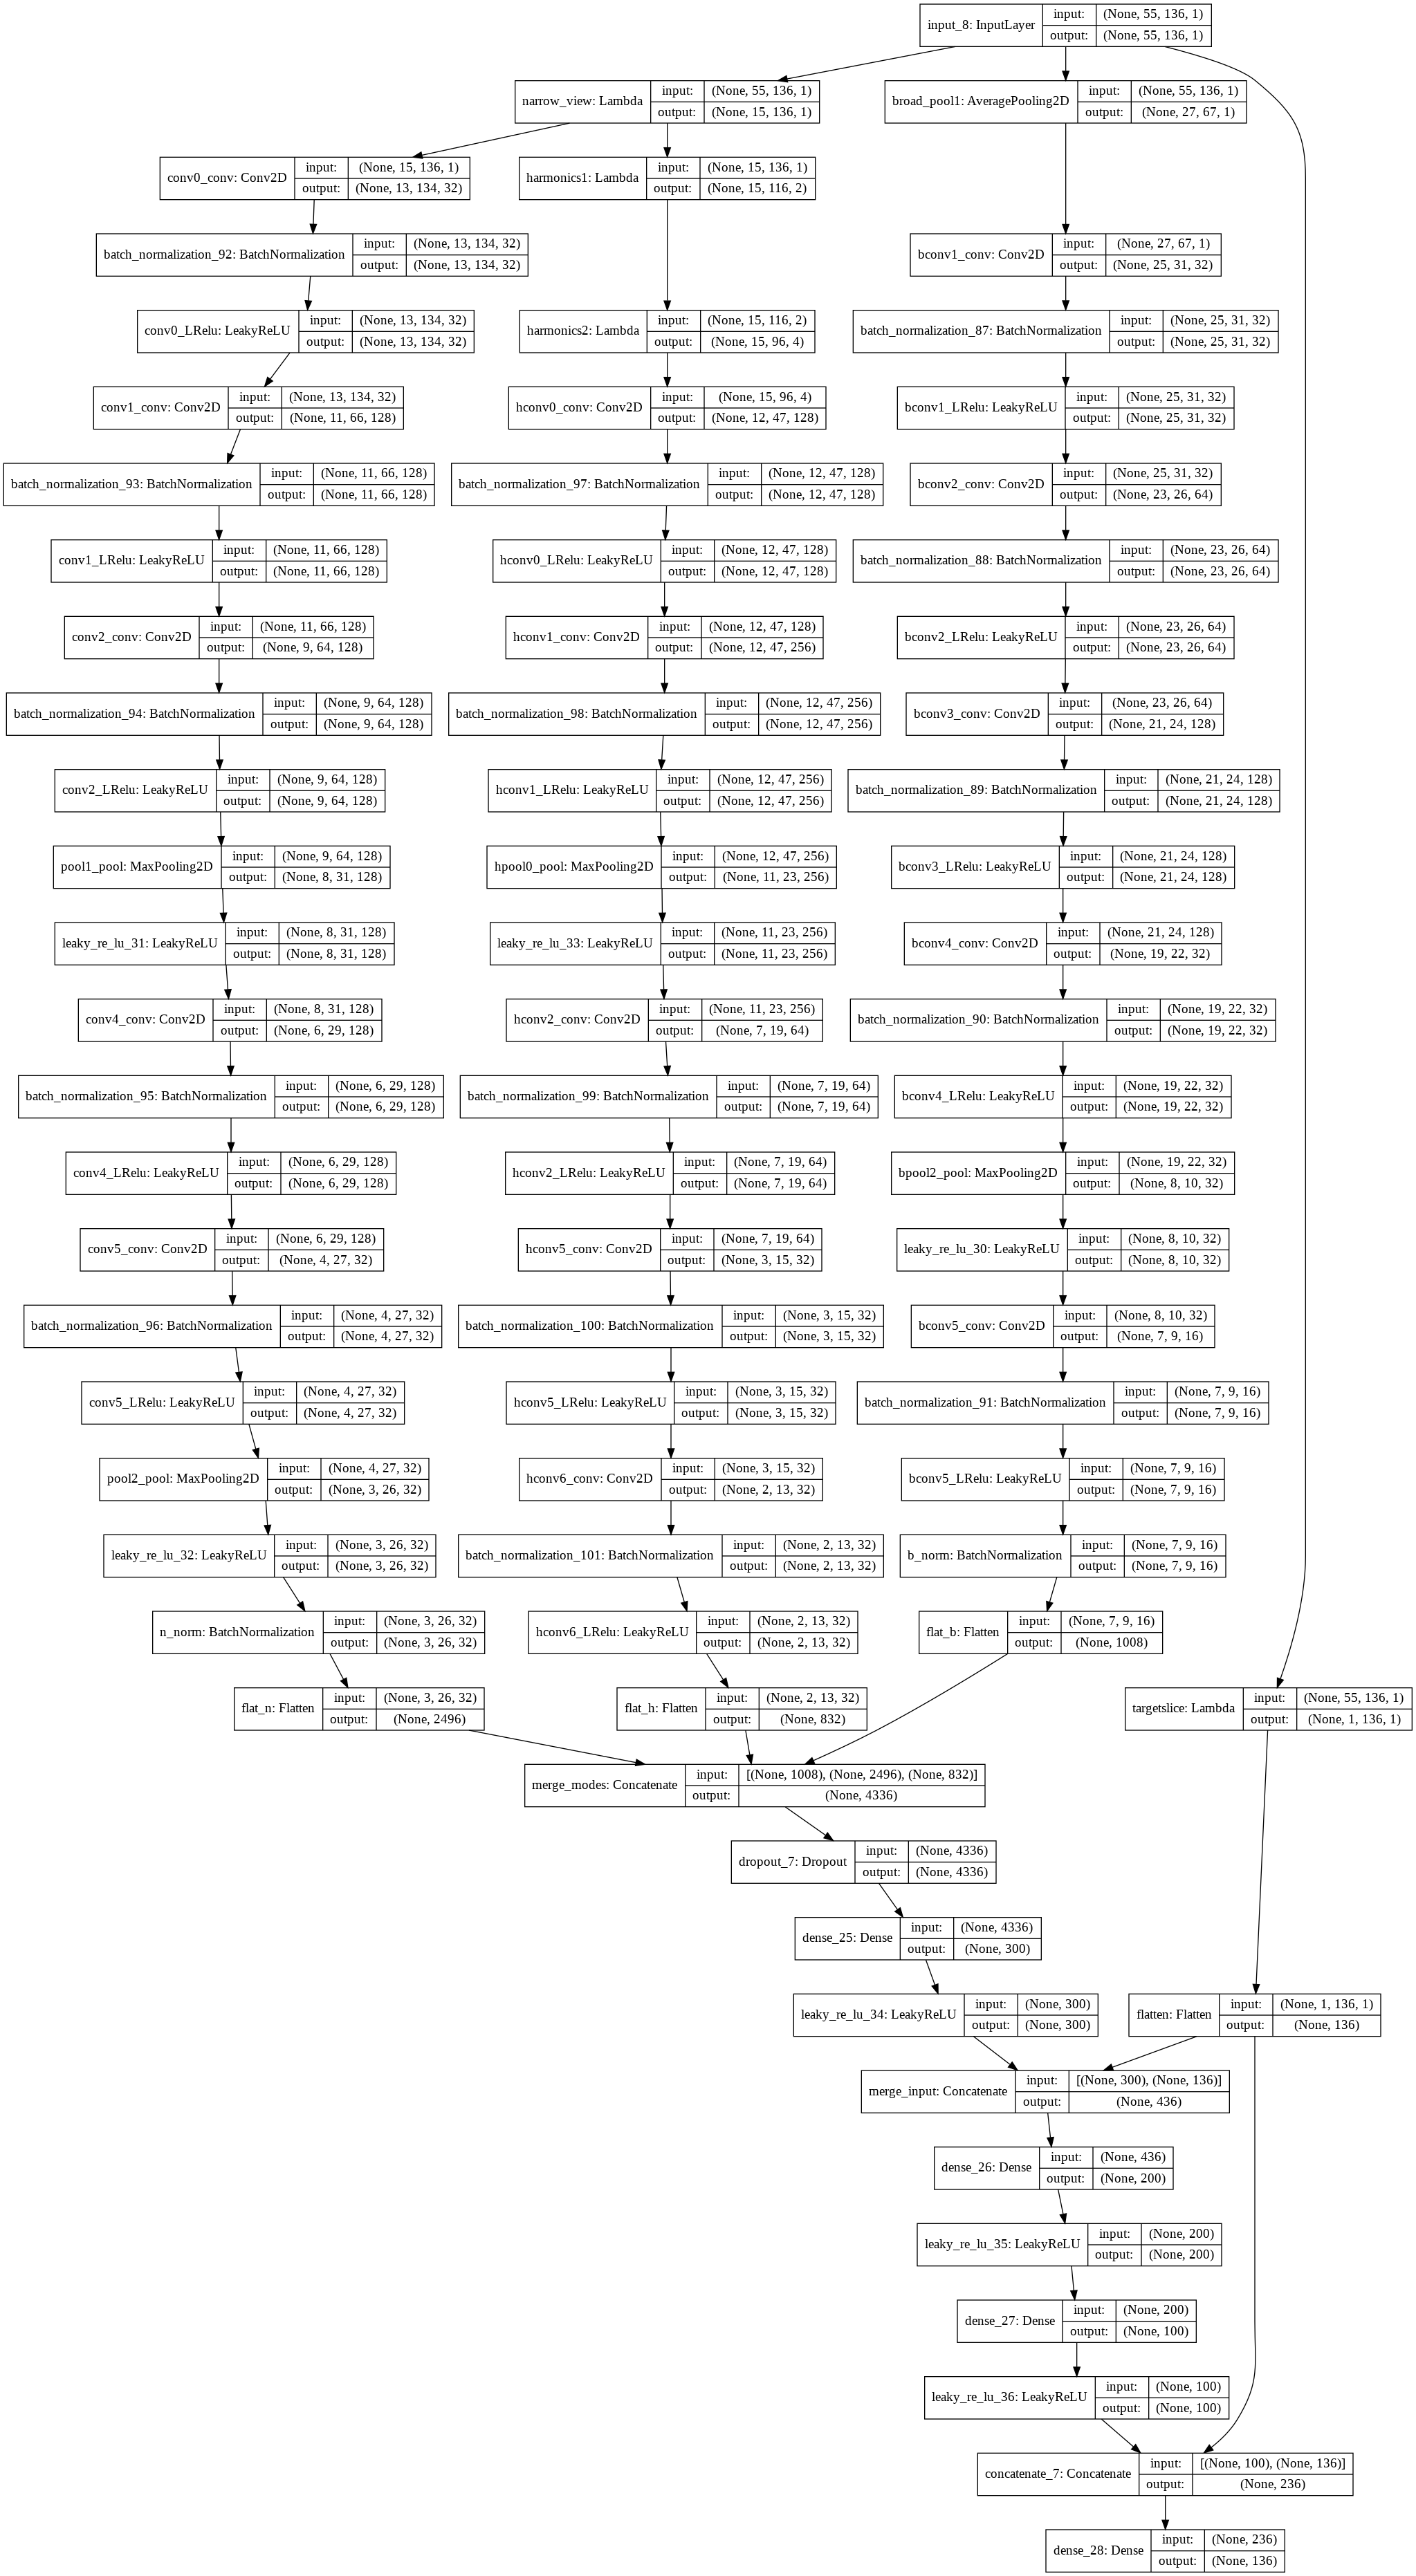

In [26]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
#model = keras.models.load_model(drive_data + "Best_model.h5")

In [27]:
#stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(drive_data + "Best_model.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

logdir = drive_data+"logs/" + time.strftime('%Y-%m-%d_%H-%M')
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Max queue size is to fix "UserWarning: The input 6833 could not be retrieved. It could be because a worker has died."
#  10 didn't work once for 500K samples, 1025 bins but tried 5 and that seemed to
#  Seems to be fixed by copying files to VM local drive
hist = model.fit_generator(generator=training_generator, validation_data=validation_generator, epochs=10, callbacks = [save_best, tensorboard_callback]) #, max_queue_size=10)

Epoch 1/10
370/370 [==============================] - 116s 314ms/step - loss: 1.3578 - val_loss: 0.4816
Epoch 2/10
370/370 [==============================] - 113s 305ms/step - loss: 0.3383 - val_loss: 0.2380
Epoch 3/10
166/370 [============>.................] - ETA: 1:01 - loss: 0.2409

KeyboardInterrupt: ignored

In [0]:
now = time.strftime('%Y-%m-%d_%H-%M')
model.save(drive_data + "model_"+now+".h5")

In [12]:
history = hist

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.ylim((0, 2 * history.history['loss'][0])) # because sometimes there are stupid spikes in error
plt.show()

#plt.savefig('test.png')
print("Validation loss mean 5+ epochs {0:.4}".format(np.mean(history.history['val_loss'][5:])))
print("Lowest validation loss {0:.4}".format(np.min(history.history['val_loss'][5:])))
print("Frames ", frames.shape[0])

NameError: ignored

In [0]:
# some test data to hack around with
test_file = "Assets\\DataShareArchive\\Test\\Clean\\p232_010.wav"
wav, rate = librosa.core.load(test_file)
fft = get_ft(wav)
#print(fft.shape)

In [0]:
# Full round trip test
file = "p232_001.wav"

verify_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file


# Sample output is (samples, bins) all converted to magnitude
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples

# Only need this for testing at this point?  Could still make it a 'top' type shared function
def clip_frames(file):
    samples = get_samples(file)
    print(samples.shape)
    frames = np.empty((samples.shape[0], WINDOW_SIZE, FFT_BINS, 1))
    half_win = WINDOW_SIZE//2
    for i in range(half_win, samples.shape[0]-half_win):
        frames[i,:,:,0] = samples[i-half_win:i+half_win+1,:]
    return frames


def clean_clip(model, n_file):
    verify_frames = clip_frames(n_file)
    output_targets = model.predict([verify_frames])
    wav, rate = librosa.core.load(n_file)
    n_fft = get_ft(wav)
    fft = rebuild_fft(output_targets, n_fft)
    return fft, inv_ft(fft)


p_fft, p_wav = clean_clip(model, verify_file)
    
wav, rate = librosa.core.load(clean_file)
c_fft = get_ft(wav)


def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='cqt_hz', x_axis='time')

print("Cleaned clip")

err_fft = c_fft - p_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

display_fft(p_fft)
Audio(p_wav,rate=22050)


In [0]:
def draw(wav):
    fft = get_ft(wav)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='cqt_hz', x_axis='time')
    return fft

In [0]:
wav, rate = librosa.core.load(verify_file)
n_fft = draw(wav)

err_fft = c_fft - n_fft
print("Average abs err vs clean = ", np.mean(abs(err_fft)))

print("Noisy file")
Audio(wav, rate=rate)

In [0]:
wav, rate = librosa.core.load(clean_file)
c_fft = draw(wav)

print("Clean sample")
Audio(wav, rate=rate)

In [0]:
cut_fft = n_fft-p_fft
display_fft(cut_fft)

print("Removed audio")
print("Average cut value = ", np.mean(abs(cut_fft)))

cut_wav = inv_ft(cut_fft)
Audio(cut_wav,rate=22050)


In [0]:
#%%capture cap
print(model.summary())
#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)


In [0]:
fresh_wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\Noisy\\p232_019.wav")
Audio(fresh_wav, rate=rate)

Test & reference stuff 

In [0]:
ft = clip_frames(test_file)
tt = clip_targets(test_file)

print(ft.shape)
print(tt.shape)

#Frame / target check  -  don't use first row because it might be zeroed out
r = 10
print(tt[0,r])
print(ft[0,r,TARGET_COL:TARGET_COL+1,0])

# Round trip test
new_fft = rebuild_fft(tt, fft)
print(new_fft.shape)
new_wav = inv_ft(new_fft)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

Audio(new_wav,rate=22050)

In [0]:
    
def show_fft(wav):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max), y_axis='log', x_axis='time')

def display_fft(ft):
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(fft), ref=np.max), y_axis='log', x_axis='time')

librosa.display.specshow(librosa.amplitude_to_db(np.abs(new_fft), ref=np.max), y_axis='log', x_axis='time')

print(new_fft.shape)

#show_fft(wav)
#show_fft(new_wav)
#Audio(wav, rate=22050)


In [0]:
# Test stuff for hacking around    
    
a = np.array([[1+2j, 3+4j, 1.5+2.5j],[5+6j,7+8j, 5.5+6.5j]])
print(a)
a1 = a[0]
print(a1)
ar = a1.real
ai = a1.imag

st = np.zeros((6))
st[0:3] = ar
st[3:6] = ai
print(ar.shape, ai.shape, st.shape)
print(ar, ai)
print(st)


In [0]:
# ''do nothing' model that should be able to guess outputs from outputs

inputs = layers.Input(shape=(FFT_BINS*2,))
dense1 = layers.Dense(2000, activation='relu')(inputs)
dense2 = layers.Dense(2000, activation='relu')(dense1)
#flat = layers.Flatten()(dense)
#flat_in = layers.Flatten()(inputs)
#merged = layers.concatenate([flat, flat_in])
merged = layers.concatenate([dense2, inputs])
linear = layers.Dense(2000, activation='linear')(merged)
outputs = layers.Dense(2*FFT_BINS, activation='linear')(linear)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='Adam', loss='mse')

model.fit(targets, targets, epochs=1, batch_size=32)